### test 1

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [2]:
import json
from datetime import datetime, time, timedelta

# 定义 AR(1) 模型的参数
parameters = {
    "phi": 0.8,    # AR(1)系数
    "sigma": 1,    # 噪声标准差
    "N": 5000      # 时间步长
}

# 将参数保存在 JSON 文件中
parameters_filepath = './arma_parameters.json'
with open(parameters_filepath, 'w') as file:
    json.dump(parameters, file)

parameters_filepath


'arma_parameters.json'

In [3]:
from pandas.tseries.offsets import BDay

# 加载 JSON 文件中的参数
with open(parameters_filepath, 'r') as file:
    params = json.load(file)

phi = params['phi']
sigma = params['sigma']
N = params['N']

# 定义工作日的时间范围
start_time = time(9, 30)
end_time = time(15, 0)

# 计算每个工作日内有多少分钟
minutes_per_day = (datetime.combine(datetime.min, end_time) - datetime.combine(datetime.min, start_time)).seconds // 60

# 创建时间序列的索引
def create_datetime_index(N, start_datetime, start_time, end_time):
    business_days = pd.date_range(start=start_datetime, periods=N, freq=BDay())
    datetime_index = pd.DatetimeIndex([])
    current_datetime = start_datetime
    
    while len(datetime_index) < N:
        if current_datetime.time() >= start_time and current_datetime.time() < end_time:
            datetime_index = datetime_index.append(pd.DatetimeIndex([current_datetime]))
        current_datetime += timedelta(minutes=1)
        # 如果是非工作时间，跳到下一个工作日的开始时间
        if current_datetime.time() >= end_time or current_datetime.weekday() >= 5:
            current_datetime = (business_days[0] + BDay(1)).replace(hour=start_time.hour, minute=start_time.minute)
            business_days = business_days[1:]  # 移除已经使用的工作日
    return datetime_index

# 初始化时间为 pandas.Timestamp("2000-03-06 09:30:00")
start_datetime = pd.Timestamp("2000-03-06 09:30:00")
datetime_index = create_datetime_index(N, start_datetime, start_time, end_time)

# 模拟时间序列
def simulate_ar1_series(phi, sigma, N, datetime_index):
    # 初始化时间序列
    time_series = pd.Series(index=datetime_index, dtype=float)
    # 生成白噪声
    noise = np.random.normal(0, sigma, size=N)
    # 设置初始值
    time_series.iloc[0] = noise[0]
    # 模拟 AR(1) 过程
    for i in range(1, N):
        time_series.iloc[i] = phi * time_series.iloc[i-1] + noise[i]
    return time_series

# 模拟单个时间序列
simulated_series = simulate_ar1_series(phi, sigma, N, datetime_index)
simulated_series.head()


2000-03-06 09:30:00    2.861596
2000-03-06 09:31:00    2.526740
2000-03-06 09:32:00    1.836514
2000-03-06 09:33:00    2.235094
2000-03-06 09:34:00    1.849142
dtype: float64

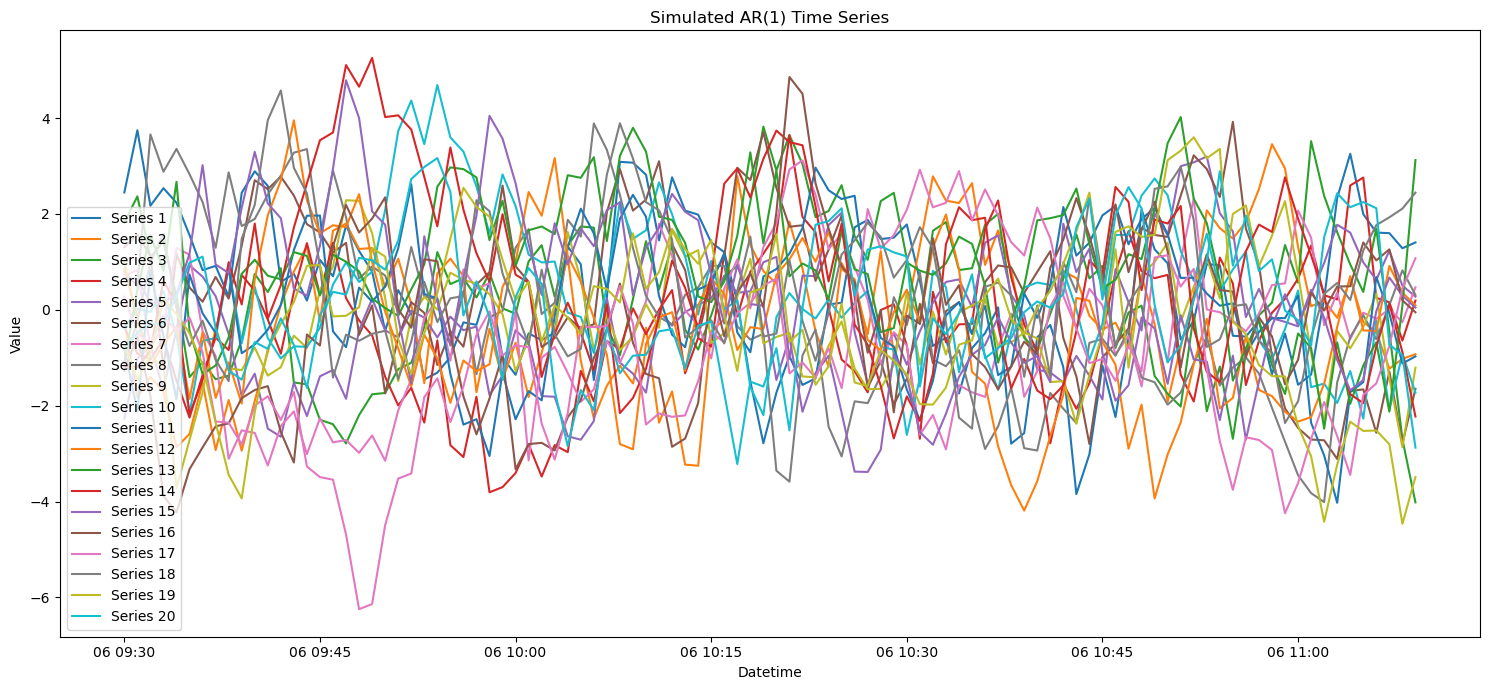

In [4]:
# 模拟 20 个时间序列并绘制它们
plt.figure(figsize=(15, 7))

# 由于绘制所有 5000 个点的时间序列可能会导致图表变得拥挤不清晰，我们选择绘制前 100 个数据点
for i in range(20):
    simulated_series = simulate_ar1_series(phi, sigma, N, datetime_index)
    plt.plot(simulated_series.index[:100], simulated_series[:100], label=f'Series {i+1}')

plt.title('Simulated AR(1) Time Series')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# 使用 ARIMA 类估计单个时间序列的参数
model = ARIMA(simulated_series, order=(1, 0, 0))
model_fit = model.fit()

# 获取估计的 AR(1) 参数
estimated_phi = model_fit.params['ar.L1']

# 比较真实值和估计值
estimated_phi, phi


/home/wangs/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wangs/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/wangs/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


(0.8052492249687989, 0.8)

### test 2

In [44]:
# 我们将进行数据总结，包括计算汇总统计数据和生成图表
# 我们将使用三种不同的方法来预测最后20%的价格

# 加载数据
pv_data = pd.read_csv('pv.csv')

# 将日期列转换为 datetime 对象，并设置为索引
pv_data['Date'] = pd.to_datetime(pv_data['Date'])
pv_data.set_index('Date', inplace=True)
pv_data.sort_index(ascending=True,inplace=True)
pv_data['Close'] = pv_data['Close'].replace('[\$,]', '', regex=True).astype(float)
pv_data['Open'] = pv_data['Open'].replace('[\$,]', '', regex=True).astype(float)
pv_data['High'] = pv_data['High'].replace('[\$,]', '', regex=True).astype(float)
pv_data['Low'] = pv_data['Low'].replace('[\$,]', '', regex=True).astype(float)
# 更新转换函数以处理 'K', 'M', 以及 'B' 后缀
def convert_volume_with_billion(volume_str):
    # 检查并移除后缀，然后将值转换为浮点数，并乘以相应的数值
    if 'K' in volume_str:
        return float(volume_str.rstrip('K')) * 1e3
    elif 'M' in volume_str:
        return float(volume_str.rstrip('M')) * 1e6
    elif 'B' in volume_str:
        return float(volume_str.rstrip('B')) * 1e9
    else:
        return float(volume_str)


pv_data['Volume'] = pv_data['Volume'].apply(convert_volume_with_billion)
# 计算每日收盘价格的百分比变化
pv_data['ret'] = pv_data['Close'].pct_change(1)
# 计算汇总统计数据
pv_data_description = pv_data.describe()

pv_data_description

,Close,Open,High,Low,Volume,ret
count,1106.000000,1106.000000,1106.000000,1106.000000,1.106000e+03,1105.000000
mean,28778.358951,28769.478481,29520.326492,27923.271519,5.506702e+07,0.001564
std,17066.832431,17075.785319,17546.113853,16524.599183,3.258311e+08,0.038473
min,4826.000000,4815.200000,5369.300000,3869.500000,2.600000e+02,-0.391816
25%,11710.275000,11686.100000,11827.325000,11470.850000,8.107250e+04,-0.015399
50%,23305.800000,23305.800000,24082.800000,22824.650000,1.580600e+05,0.000796
75%,42813.775000,42810.200000,43903.725000,41829.350000,4.697650e+05,0.018808
max,67527.900000,67528.700000,68990.600000,66334.900000,4.470000e+09,0.194137


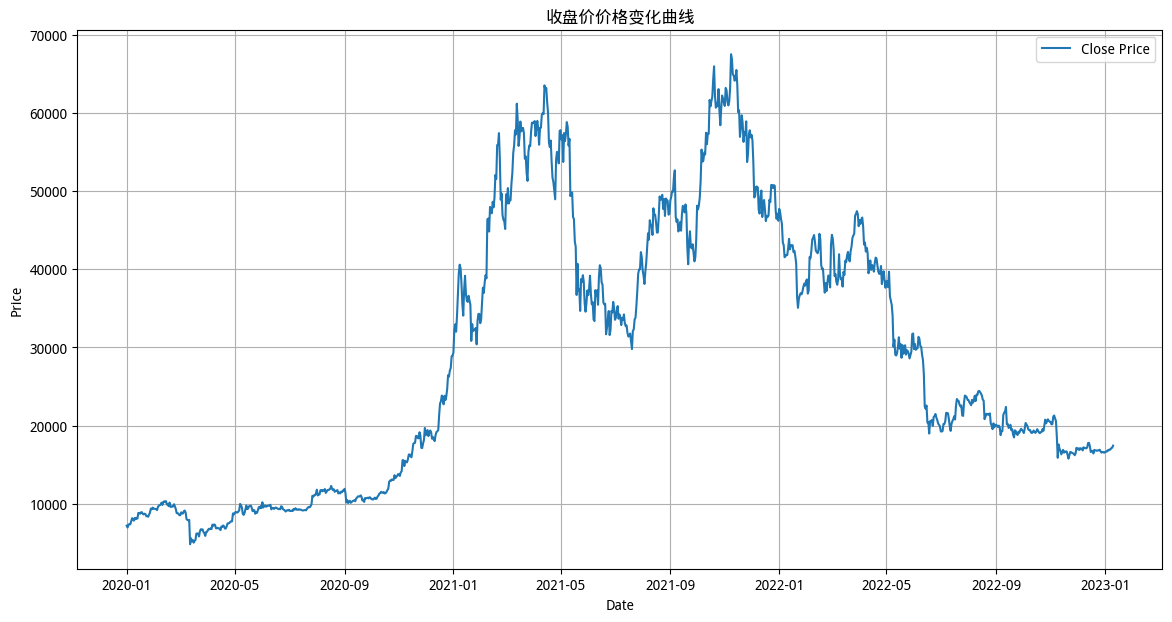

In [26]:
# 绘制价格图表
import matplotlib as mpl  

mpl.rc("font",family='Droid Sans Fallback',weight="bold")
plt.figure(figsize=(14, 7))
plt.plot(pv_data.index, pv_data['Close'], label='Close Price')
plt.title('收盘价价格变化曲线')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

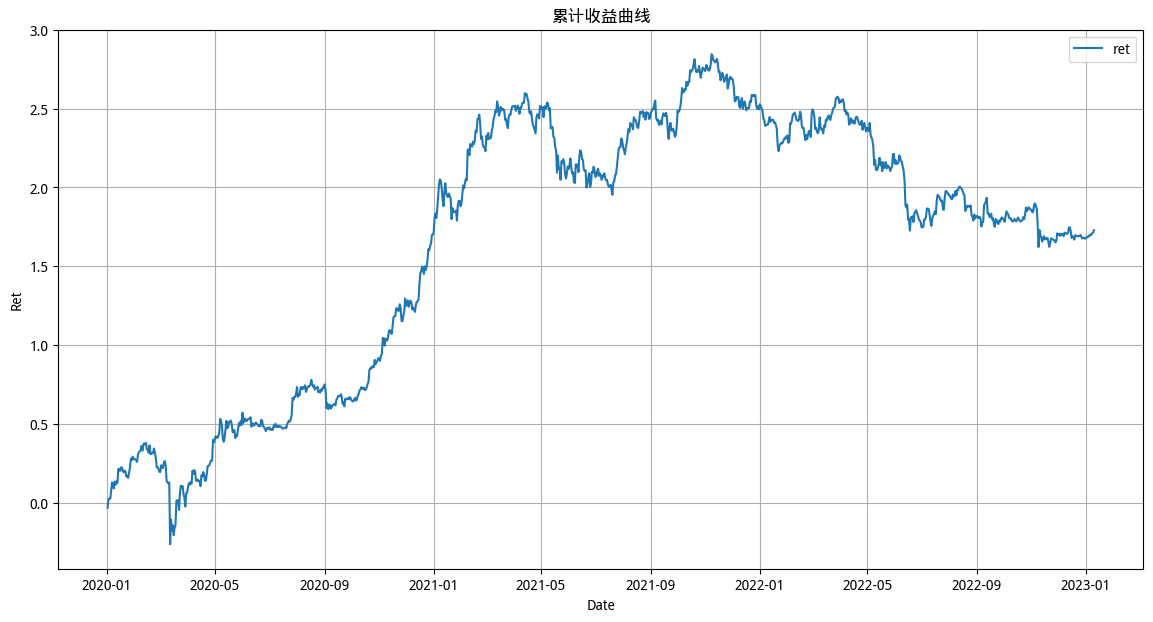

In [27]:
# 绘制收益率累积折现图
plt.figure(figsize=(14, 7))
plt.plot(pv_data.index, pv_data['ret'].cumsum(), label='ret')
plt.title('累计收益曲线')
plt.xlabel('Date')
plt.ylabel('Ret')
plt.legend()
plt.grid(True)
plt.show()

[]

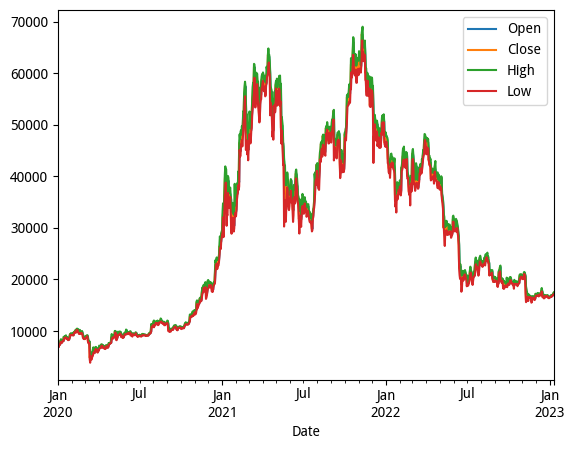

In [28]:
pv_data.Open.plot(label='Open')
pv_data.Close.plot(label='Close')
pv_data.High.plot(label='High')
pv_data.Low.plot(label='Low')
plt.legend()
plt.plot()

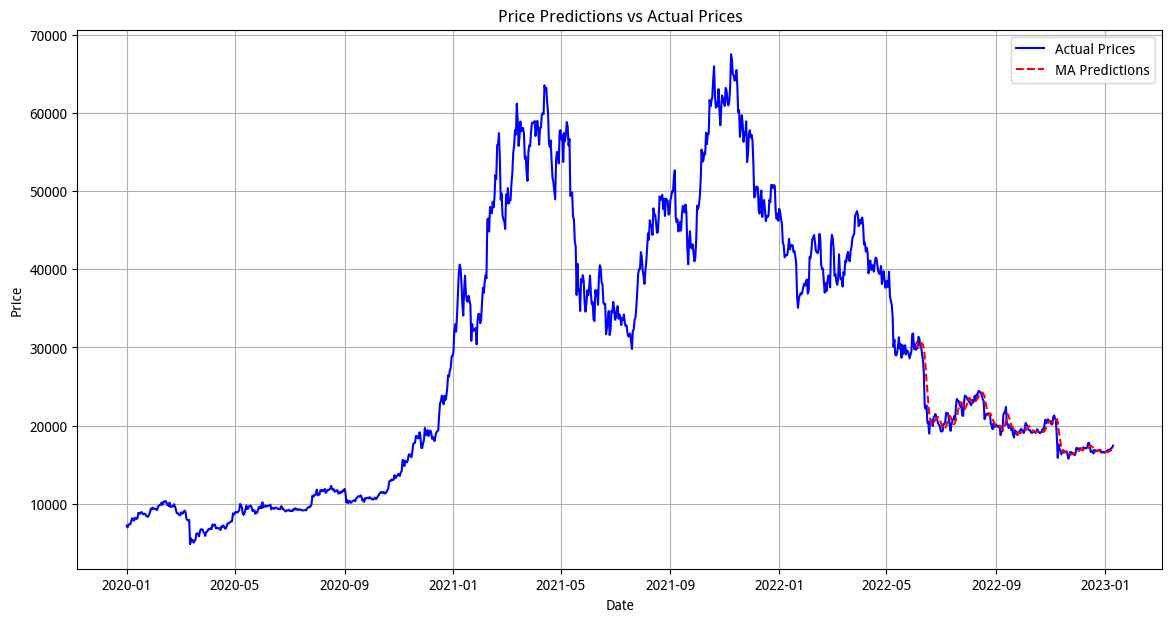

Mean Squared Error: 1202237.5179765767


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 移动平均预测的函数
def rolling_forecast(train_data, test_data, window_size):
    predictions = []
    rolling_window = train_data[-window_size:].tolist()
    for new_value in test_data:
        new_pred = np.mean(rolling_window)
        predictions.append(new_pred)
        # Update the rolling window
        rolling_window.append(new_value)
        rolling_window.pop(0)
    return predictions

# 划分数据集
train_size = int(len(pv_data) * 0.8)
test_size = len(pv_data) - train_size
train_set = pv_data.iloc[:train_size].copy()  # 使用 .copy() 避免 SettingWithCopyWarning
test_set = pv_data.iloc[train_size:]

# 使用一个窗口大小为 5 的移动平均来预测
window_size = 5
ma_predictions = rolling_forecast(train_set['Close'].values, test_set['Close'].values, window_size)

# 可视化预测结果
plt.figure(figsize=(14, 7))
plt.plot(pv_data.index, pv_data['Close'], label='Actual Prices', color='blue')
plt.plot(test_set.index, ma_predictions, label='MA Predictions', color='red', linestyle='--')
plt.title('Price Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 计算均方误差
mse = mean_squared_error(test_set['Close'], ma_predictions)
print(f'Mean Squared Error: {mse}')

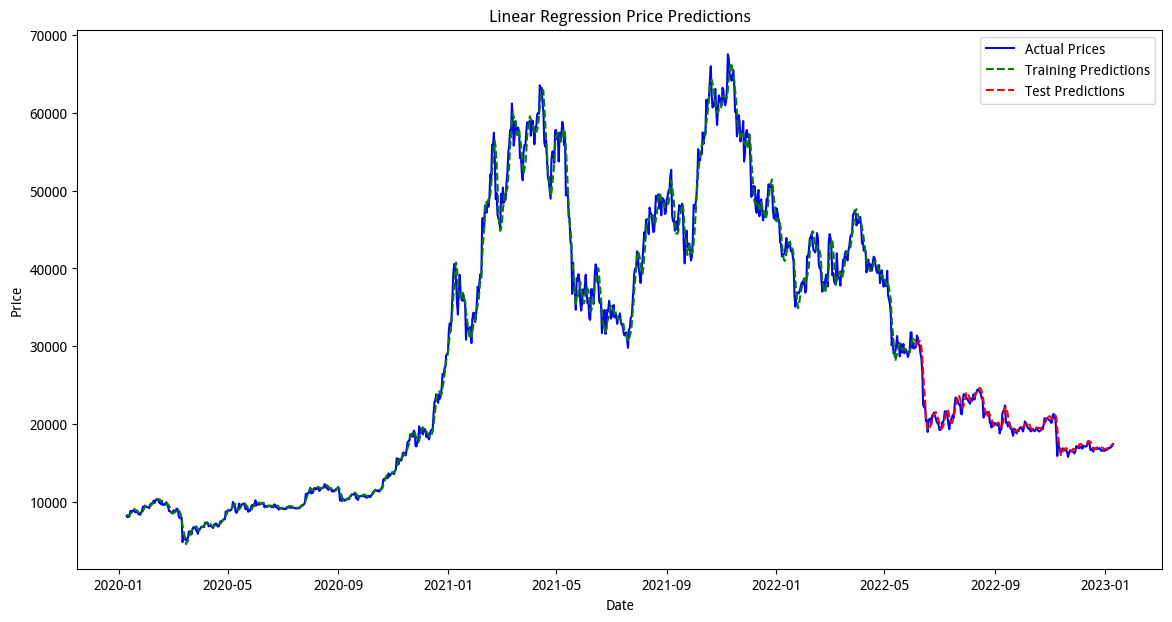

Mean Squared Error: 575214.7786807668


In [47]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假设 pv_data 是已经加载好的 DataFrame，包含日期和价格信息
# pv_data = ...

# 添加额外的特征，例如 5 天和 10 天的滑动平均
pv_data['MA_5'] = pv_data['Close'].rolling(window=5).mean()
pv_data['MA_10'] = pv_data['Close'].rolling(window=10).mean()

# 处理缺失值
pv_data.dropna(inplace=True)

# 创建时间特征
pv_data['Time'] = np.arange(len(pv_data))

# 划分数据集
train_size = int(len(pv_data) * 0.8)
train_set = pv_data.iloc[:train_size]
test_set = pv_data.iloc[train_size:]

# 特征和标签
X_train = train_set[['Time', 'MA_5', 'MA_10']]
y_train = train_set['Close']
X_test = test_set[['Time', 'MA_5', 'MA_10']]
y_test = test_set['Close']

# 训练线性回归模型
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 进行预测
train_predictions = lin_reg.predict(X_train)
test_predictions = lin_reg.predict(X_test)

# 可视化
plt.figure(figsize=(14, 7))
plt.plot(pv_data.index, pv_data['Close'], label='Actual Prices', color='blue')
plt.plot(train_set.index, train_predictions, label='Training Predictions', color='green', linestyle='--')
plt.plot(test_set.index, test_predictions, label='Test Predictions', color='red', linestyle='--')
plt.title('Linear Regression Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 计算均方误差
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Squared Error: {mse}')


In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 假设 pv_data 是已经加载好的 DataFrame，包含日期和价格信息
# pv_data = ...

# 添加额外的特征
pv_data['MA_5'] = pv_data['Close'].rolling(window=5).mean()
pv_data['MA_10'] = pv_data['Close'].rolling(window=10).mean()

# 处理缺失值
pv_data_ = pv_data.dropna()

# 创建时间特征
pv_data_['Time'] = np.arange(len(pv_data_))

# 划分数据集
train_size = int(len(pv_data_) * 0.8)
train_set = pv_data_.iloc[:train_size]
test_set_ = pv_data_.iloc[train_size:]

# 特征和标签
X_train = train_set[['Time', 'MA_5', 'MA_10']]
y_train = train_set['Close']
X_test = test_set_[['Time', 'MA_5', 'MA_10']]
y_test = test_set_['Close']

from sklearn.model_selection import GridSearchCV

# 参数网格
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# 创建随机森林模型
rf = RandomForestRegressor(random_state=42)

# 网格搜索
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 打印最佳参数
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/tmp/ipykernel_3961010/3024231099.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_data_['Time'] = np.arange(len(pv_data_))


Best Parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


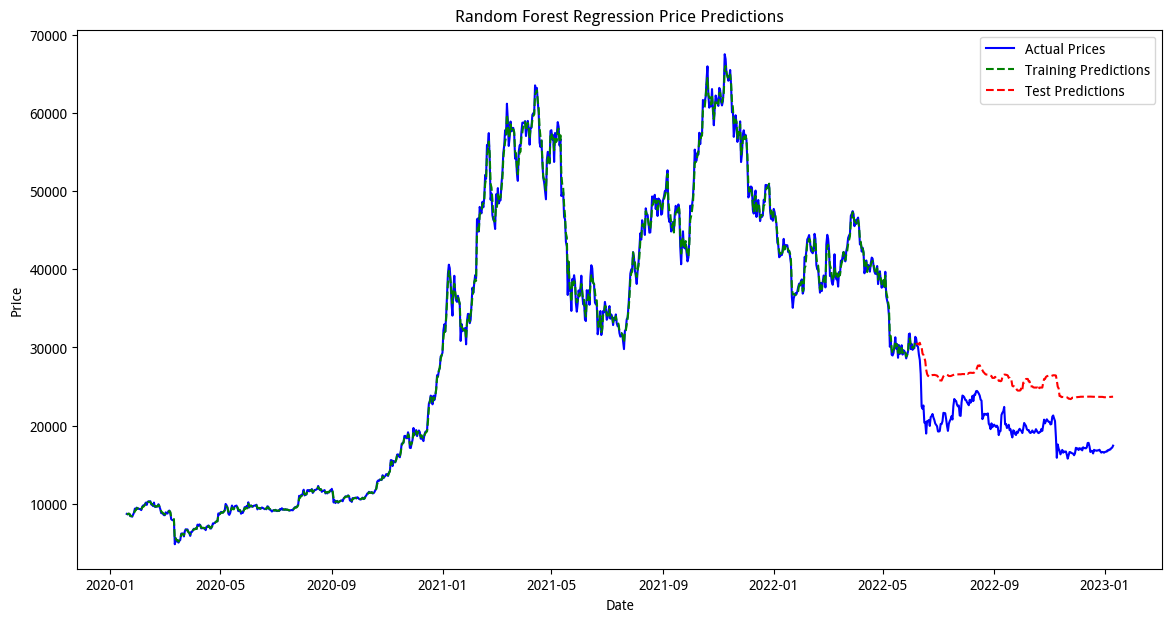

Mean Squared Error: 34927089.74160308


In [52]:
# 训练随机森林模型
rf_reg = RandomForestRegressor(n_estimators=10000, min_samples_split=2, min_samples_leaf=1, max_features='auto', random_state=42)
rf_reg.fit(X_train, y_train)

# 进行预测
train_predictions = rf_reg.predict(X_train)
rf_predictions = rf_reg.predict(X_test)

# 可视化
plt.figure(figsize=(14, 7))
plt.plot(pv_data_.index, pv_data_['Close'], label='Actual Prices', color='blue')
plt.plot(train_set.index, train_predictions, label='Training Predictions', color='green', linestyle='--')
plt.plot(test_set_.index, rf_predictions, label='Test Predictions', color='red', linestyle='--')
plt.title('Random Forest Regression Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 计算均方误差
mse = mean_squared_error(y_test, rf_predictions)
print(f'Mean Squared Error: {mse}')